# 충남대학교 컴퓨터비전
# Interest point

## 목차
### 1. Difference of Gaussian
### 2. Harris Corner Detection implementation with Integral image


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 이미지 불러오기 - 경로 /content에 이미지 파일 업로드
#from google.colab import files
#file_uploaded = files.upload()

## 1 Difference of Gaussian

### 1.1 DoG(Difference of Gaussian) 정의
- 서로 다른 Gaussian blur를 적용한 두 이미지의 차(Subtraction)


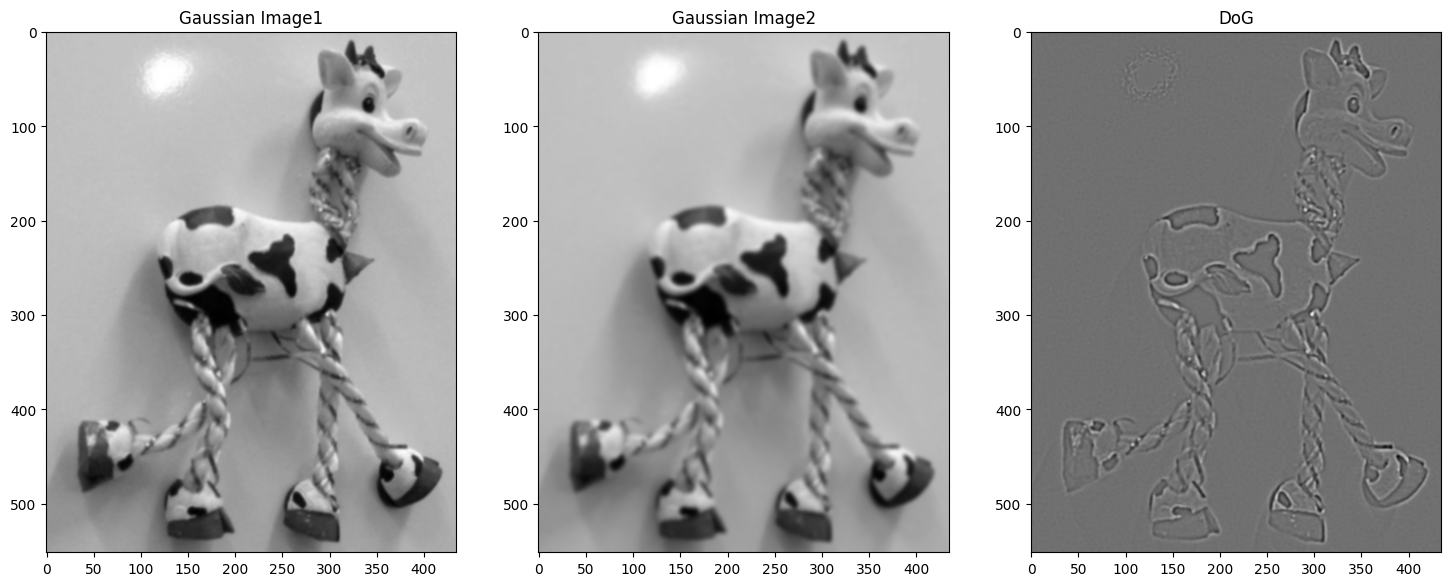

In [4]:
image = cv2.imread('./zebra.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255

def my_padding(src, filter):

    (h, w) = src.shape
    if isinstance(filter, tuple):
        (h_pad, w_pad) = filter
    else:
        (h_pad, w_pad) = filter.shape

    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h+h_pad*2, w+w_pad*2))
    padding_img[h_pad:h+h_pad, w_pad:w+w_pad] = src

    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img

def my_filtering(src, filter):

    (h, w) = src.shape
    (f_h, f_w) = filter.shape

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w), dtype=np.float32)
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst

def my_get_Gaussian_filter(fshape, sigma=1):
    (f_h, f_w) = fshape
    y, x = np.mgrid[-(f_h // 2):(f_h // 2) + 1, -(f_w // 2):(f_w // 2) + 1]
    #2차 gaussian mask 생성
    filter_gaus =  1 / (2 * np.pi * sigma**2) * np.exp(-(( x**2 + y**2 )/(2 * sigma**2)))
    #mask의 총 합 = 1
    filter_gaus /= np.sum(filter_gaus)
    return filter_gaus


def plot_results(output_list=[]):

  plt.rcParams['figure.figsize'] = (18, 8)
  rows = 1
  cols = 3
  output_name_list = ['Gaussian Image1', 'Gaussian Image2', 'DoG']

  for i in range(3):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)
    plt.imshow(output_list[i], cmap='gray')

  plt.show()
  return


# gaussian filter 크기
kernel_size = 9
sigma1 = 1.0
sigma2 = 2.0

kernel1 = my_get_Gaussian_filter((kernel_size, kernel_size), sigma1)
kernel2 = my_get_Gaussian_filter((kernel_size, kernel_size), sigma2)

gaussian_img1 = my_filtering(gray_image, kernel1)
gaussian_img2 = my_filtering(gray_image, kernel2)

# dog image 생성
dog_image = gaussian_img1 - gaussian_img2
dog_image = (dog_image - dog_image.min()) / (dog_image.max() - dog_image.min())
plot_results([gaussian_img1, gaussian_img2, dog_image])




Gaussian pyramids
calc Diffrence of Gaussian


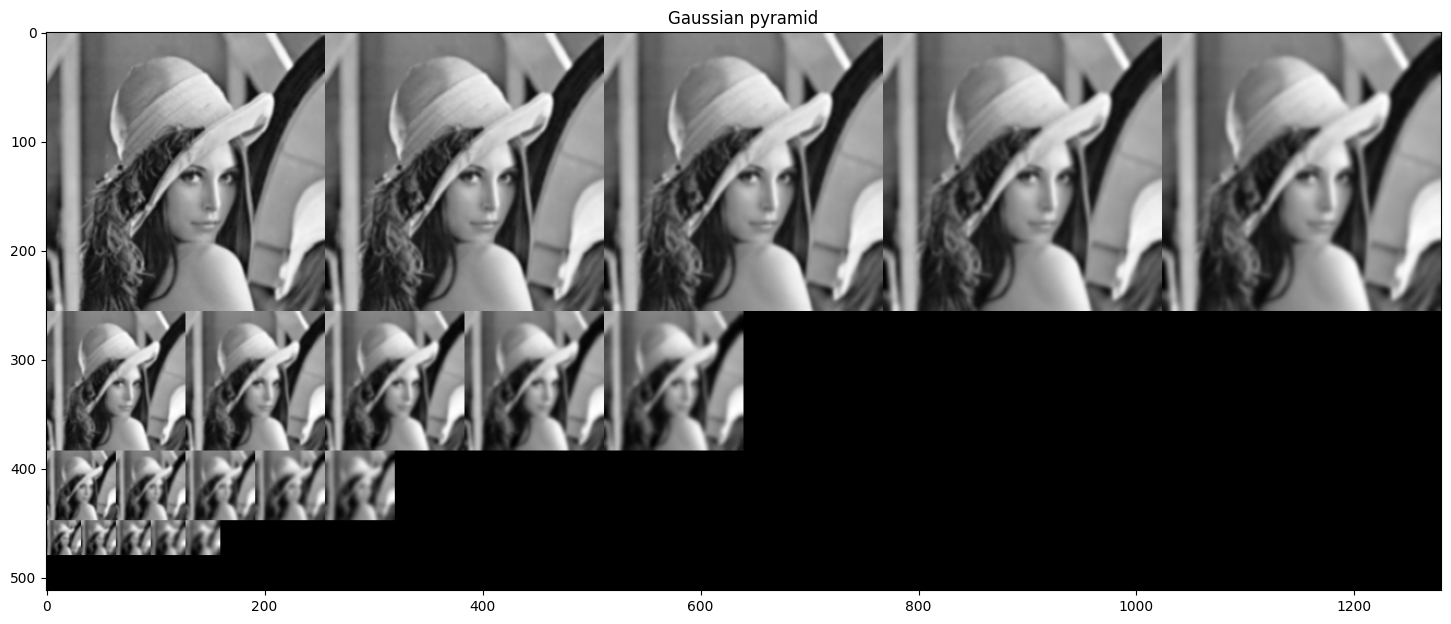

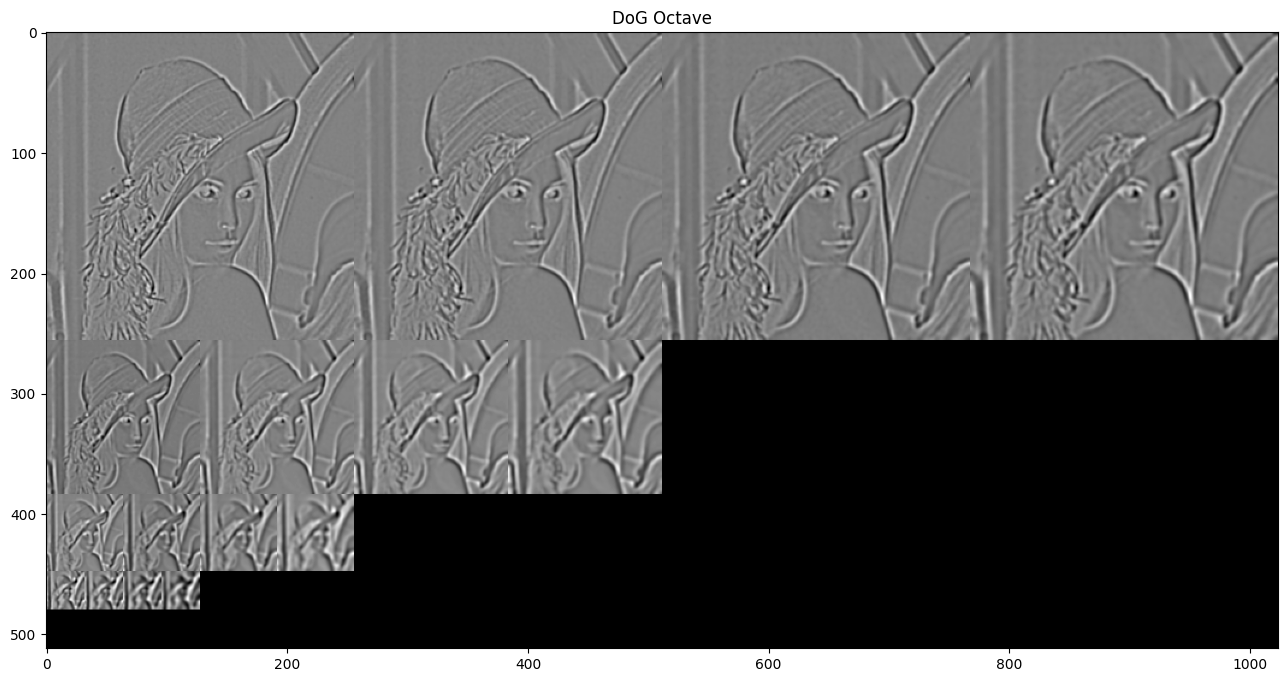

In [5]:
def DoG_pyramids(src, level=5, l=4):

    s = 1. #sigma
    a = l  #extrema point
    k = 2. ** (1/a) #step

    sigma = []
    for n in range(4):
        level_sigma = []
        for l in range(level):
            level_sigma.append(s * (k ** (n * (level - 1) + l)))
        sigma.append(level_sigma)

    # size는 기본 이미지에서 1/2배, 1/4배, 1/8배, 1/16배로 진행
    h, w = src.shape

    scales = [
        (h // 2, w // 2),
        (h // 4, w // 4),
        (h // 8, w // 8),
        (h // 16, w // 16)
    ]

    img = cv2.resize(src, dsize=(w//2, h//2), interpolation=cv2.INTER_LINEAR) ## 이미지를 1/2로 재조정

    gaussian_pyramids = [
        np.zeros((scales[0][0], scales[0][1], level)), #1/2
        np.zeros((scales[1][0], scales[1][1], level)), #1/4
        np.zeros((scales[2][0], scales[2][1], level)), #1/8
        np.zeros((scales[3][0], scales[3][1], level)) #1/16
    ]

    print("Gaussian pyramids")
    for s in range(4):
        for j in range(level):
            lv_sigma = sigma[s][j]
            ksize = 2 * int(4 * lv_sigma + 0.5) + 1
            gaussian = cv2.GaussianBlur(img, (ksize, ksize), lv_sigma)
            h, w = scales[s]
            gaussian = cv2.resize(gaussian, dsize=(w, h), interpolation=cv2.INTER_LINEAR) ## gaussian img를 level에 맞게 조정
            gaussian_pyramids[s][:, :, j] = gaussian


    print("calc Diffrence of Gaussian")
    DoG = [
        np.zeros((scales[0][0], scales[0][1], l)),
        np.zeros((scales[1][0], scales[1][1], l)),
        np.zeros((scales[2][0], scales[2][1], l)),
        np.zeros((scales[3][0], scales[3][1], l))
    ]

    for s in range(4):
        for i in range(l):
            next = gaussian_pyramids[s][:, :, i + 1]
            prev = gaussian_pyramids[s][:, :, i]
            DoG[s][:, :, i] = next - prev

    return gaussian_pyramids, DoG


def show_pyramids(src, d=4, h_s=2, w_s=4):

    assert len(src) == d #동일한 깊이가 아닐 시 에러
    h, w, c = src[0].shape

    assert c == w_s #동일한 채널이 아닐 시 에러
    dst = np.zeros((h * h_s, w * w_s)).astype(np.uint8)
    y = 0
    for s in range(d):
        dh, dw, _ = src[s].shape
        x = 0
        for i in range(w_s):
            dst[y:y + dh, x:x + dw] = \
                ((src[s][:, :, i] - np.min(src[s][:, :, i])) / np.max(src[s][:, :, i] - np.min(src[s][:, :, i])) * 255 + 0.5).astype(np.uint8)
            x += dw
        y += dh
    return dst


src = cv2.imread('Lena.png')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY).astype(np.float32)

gaussian_pyramids, DoG = DoG_pyramids(gray)

DoG_result = show_pyramids(DoG, d=4, h_s=2, w_s=4)
gaussian_result = show_pyramids(gaussian_pyramids, d=4, h_s=2, w_s=5)

plt.imshow(gaussian_result, cmap='gray')
plt.title('Gaussian pyramid')
plt.show()

plt.imshow(DoG_result, cmap='gray')
plt.title('DoG Octave')
plt.show()

### 1.2 Difference of Gaussian을 통한 Keypoint 추출


#### 1.2.1 Difference of Gaussian을 통한 Keypoint 추출 Naive version
- 이미지의 다양한 스케일을 고려하지 않고(octave가 1) 서로 다른 `sigma` 으로 적용된 두 가우시안 이미지의 차에서 극값에 해당하는 픽셀 좌표를 keypoint로 설정


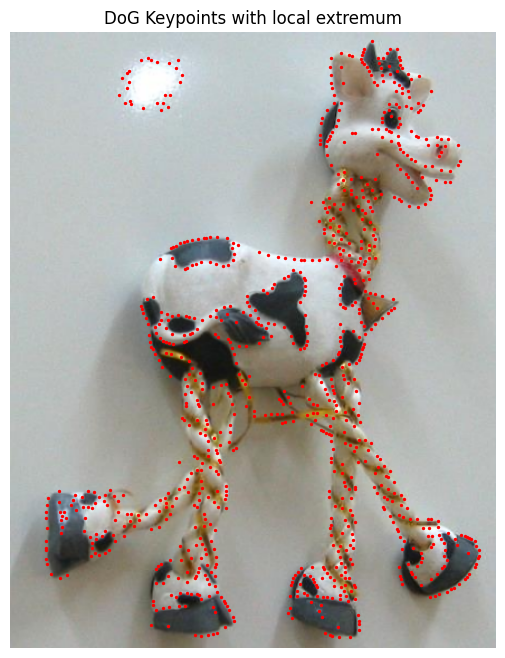

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('./zebra.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255

# DoG 파라미터
# gaussian 시그마 값들
sigma1 = 1.0
sigma2 = 2.0

# keypoint thresholding 값
threshold = 0.02

def my_padding(src, filter):

    (h, w) = src.shape
    if isinstance(filter, tuple):
        (h_pad, w_pad) = filter
    else:
        (h_pad, w_pad) = filter.shape

    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h+h_pad*2, w+w_pad*2))
    padding_img[h_pad:h+h_pad, w_pad:w+w_pad] = src

    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img

def my_filtering(src, filter):

    (h, w) = src.shape
    (f_h, f_w) = filter.shape

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w), dtype=np.float32)
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst

def my_get_Gaussian_filter(fshape, sigma=1):
    (f_h, f_w) = fshape
    y, x = np.mgrid[-(f_h // 2):(f_h // 2) + 1, -(f_w // 2):(f_w // 2) + 1]
    #2차 gaussian mask 생성
    filter_gaus =  1 / (2 * np.pi * sigma**2) * np.exp(-(( x**2 + y**2 )/(2 * sigma**2)))
    #mask의 총 합 = 1
    filter_gaus /= np.sum(filter_gaus)
    return filter_gaus

# gaussian filter 크기
kernel_size = 9
kernel1 = my_get_Gaussian_filter((kernel_size, kernel_size), sigma1)
kernel2 = my_get_Gaussian_filter((kernel_size, kernel_size), sigma2)

# dog image 생성
dog_image = my_filtering(gray_image, kernel1 - kernel2)

h, w = dog_image.shape

# 3 x 3 비교 window 크기
neighborhood_size = 3
# padding된 dog 이미지
dog_pad = my_padding(dog_image, filter=(3, 3))


local_extremum = np.zeros_like(dog_image, dtype=bool)

for i in range(h):
    for j in range(w):

        neighborhood = dog_pad[i:i + neighborhood_size, j:j + neighborhood_size]

        # 극댓값
        if dog_image[i, j] == np.max(neighborhood) and dog_image[i, j] > threshold:
            local_extremum[i, j] = True

        # 극솟값
        if dog_image[i, j] == np.min(neighborhood) and dog_image[i, j] > threshold:
            local_extremum[i, j] = True

# key point 좌표 추출
keypoints = np.argwhere(local_extremum)

plt.imshow(image[:, :, ::-1])
plt.scatter(keypoints[:, 1], keypoints[:, 0], s=2, c='red')
plt.title('DoG Keypoints with local extremum')
plt.axis('off')
plt.show()


#### 1.2.2 Difference of Gaussian을 통한 Keypoint 추출 in Scale space
- Keypoint는 한 octave 내에서 이웃한 3개의 가우시안 이미지($3 \times  3 \times 3 $)에서 기준 좌표의  픽셀 값이 이 영역에서 가장 크거나 가장 작으면 keypoint로 설정



In [7]:
# 코드출처: https://github.com/rmislam/PythonSIFT
# 코드설명: https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5

from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

logger = logging.getLogger(__name__)
float_tolerance = 1e-7

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        #keypoint.size *= 0.5
        #keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images, dtype=object)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images, dtype=object)


def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False


def my_findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    # dog_images: 옥타브 개수 x 한 옥타브 내에 있는 dog 이미지 수
    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        keypoint = KeyPoint()
                        keypoint.pt = (j * (2 ** octave_index), i * (2 ** octave_index))
                        keypoints.append(keypoint)


    return keypoints



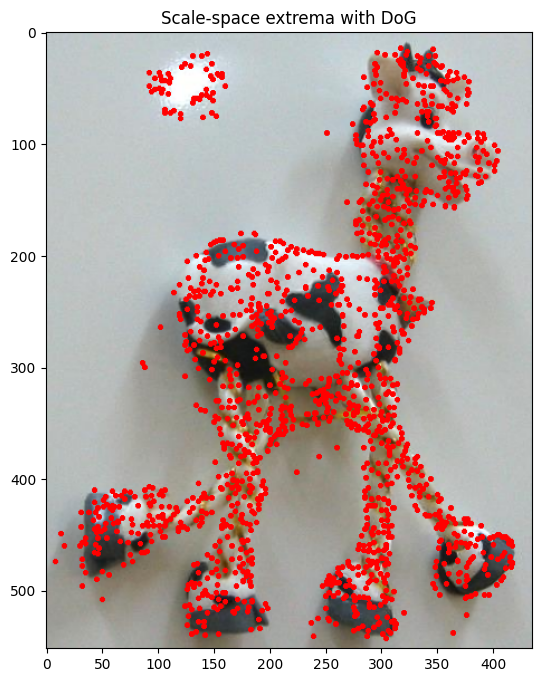

In [8]:
sigma = 1.6
num_intervals = 3
assumed_blur = 0.5
image_border_width = 5

image = cv2.imread('zebra.png', 0) # gray scale image
image = image.astype('float32')
base_image = generateBaseImage(image, sigma, assumed_blur)
num_octaves = 4
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
dog_images = generateDoGImages(gaussian_images)
keypoints = my_findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
keypoints = convertKeypointsToInputImageSize(keypoints)

output_image = cv2.imread('zebra.png')

for kp in keypoints:
  x, y = kp.pt
  cv2.circle(output_image, (int(x), int(y)), 1, (0, 0, 255), 2)



plt.imshow(output_image[:, :, ::-1])
plt.title('Scale-space extrema with DoG')
plt.show()


## 2 과제: Harris Corner Detection implementation with Integral image
- `Integral Image`를 사용하여 `Covariance Matrix`를 구하는 것과 그렇지 않은 것의 연산량 및 연산 속도 비교 과제

start!
M_harris time :  68.19166725000014
make integral image time :  0.00648379200083582
M_harris integral time :  68.52094912499979
normal vs integral 결과 비교 : True


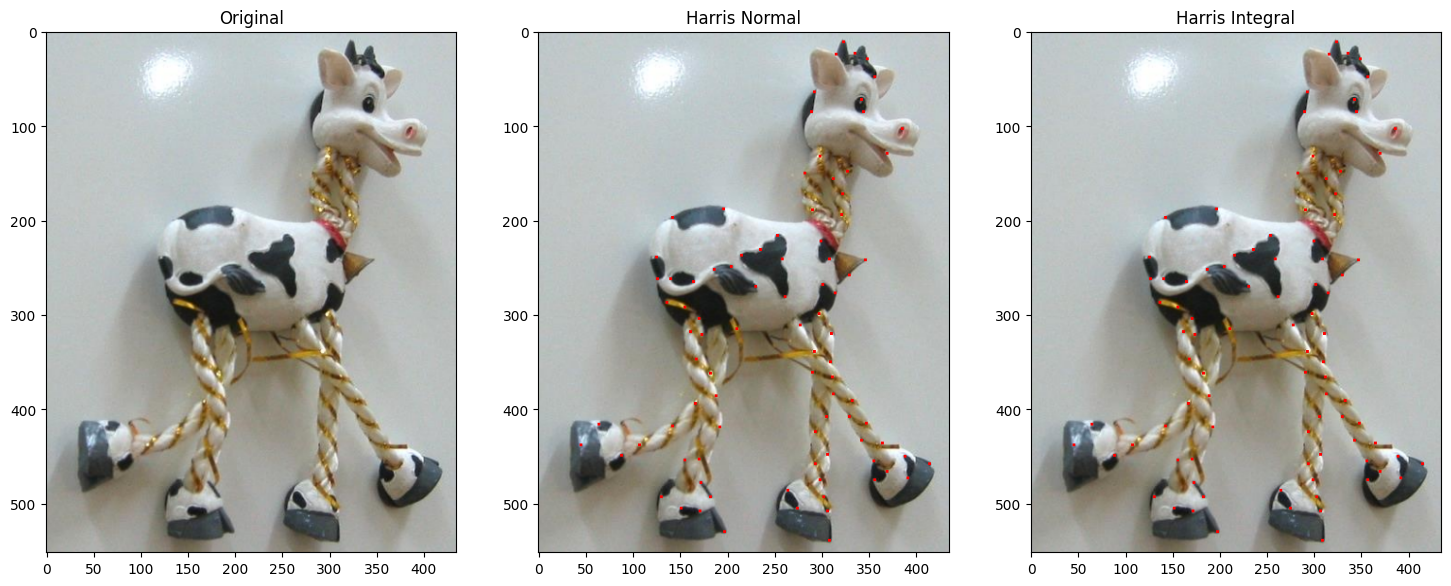

In [28]:
import numpy as np
import cv2
import time

def my_padding(src, filter):

    (h, w) = src.shape
    if isinstance(filter, tuple):
        (h_pad, w_pad) = filter
    else:
        (h_pad, w_pad) = filter.shape

    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h+h_pad*2, w+w_pad*2))
    padding_img[h_pad:h+h_pad, w_pad:w+w_pad] = src

    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img

def my_filtering(src, filter):

    (h, w) = src.shape
    (f_h, f_w) = filter.shape

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w), dtype=np.float32)
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst

def get_my_sobel():

    ##############################
    # To do
    # sobel filter 구현하기
    ##############################

    sobel_x = np.dot(np.array([[1], [2], [1]]), np.array([[-1, 0, 1]]))
    sobel_y = np.dot(np.array([[-1], [0], [1]]), np.array([[1, 2, 1]]))
    return sobel_x, sobel_y

def calc_derivatives(src):

    # calculate Ix, Iy
    sobel_x, sobel_y = get_my_sobel()
    Ix = my_filtering(src, sobel_x)
    Iy = my_filtering(src, sobel_y)
    return Ix, Iy

def find_local_maxima(src, ksize):
    (h, w) = src.shape
    pad_img = np.zeros((h+ksize, w+ksize))
    pad_img[ksize//2:h+ksize//2, ksize//2:w+ksize//2] = src
    dst = np.zeros((h, w))

    for row in range(h):
        for col in range(w):
            max_val = np.max(pad_img[row : row+ksize, col:col+ksize])
            if max_val == 0:
                continue
            if src[row, col] == max_val:
                dst[row, col] = src[row, col]

    return dst

"""
새로운 함수(integral image를 통해 해당 영역의 필터의 합을 구함)
"""
def calc_local_integral_value(src, L_top, R_bottom):
    (left_h, left_w) = L_top
    (right_h, right_w) = R_bottom
    if left_w == 0:
        left_w = 1
    if left_h == 0:
        left_h = 1
    return src[left_h - 1, left_w - 1] + src[right_h, right_w]\
            - (src[left_h - 1, right_w] + src[right_h, left_w - 1])

def calc_M_integral(src, IxIx, IxIy, IyIy, fsize = 5):

    """
    인자 정보
    src: 원본 이미지
    IxIx: Ix의 제곱 이미지의 Integral
    IyIy: Iy의 제곱 이미지의 Integral
    IxIy: Ix와 Iy를 곱한 이미지의 Integral
    fsize: sum을 할 영역
    """

    h, w, c = src.shape
    M_integral = np.zeros((h, w, 2, 2))

    ##################################################
    # To do
    # Integral 방식을 적용한 Covariance Matrix 구하기
    ##################################################
    for row in range(h):
        for col in range(w):
            M_integral[row, col, 0, 0] = calc_local_integral_value(my_padding(IxIx, (fsize, fsize)), (row, col), (row + fsize - 1, col + fsize - 1))
            M_integral[row, col, 0, 1] = calc_local_integral_value(my_padding(IxIy, (fsize, fsize)), (row, col), (row + fsize - 1, col + fsize - 1))
            M_integral[row, col, 1, 0] = M_integral[row, col, 0, 1]
            M_integral[row, col, 1, 1] = calc_local_integral_value(my_padding(IyIy, (fsize, fsize)), (row, col), (row + fsize - 1, col + fsize - 1))

    return M_integral

def get_integral_image(src):

    assert len(src.shape) == 2

    h, w = src.shape

    ##############################
    # ToDo
    # dst는 integral image
    ##############################

    dst = np.zeros(src.shape)
    dst = np.cumsum(src, axis=0)
    dst = np.cumsum(dst, axis=1)
    return dst

def calc_M_harris(IxIx, IxIy, IyIy, fsize = 5):

    """
    인자 정보
    src: 원본 이미지
    IxIx: Ix의 제곱 이미지
    IyIy: Iy의 제곱 이미지
    IxIy: Ix와 Iy를 곱한 이미지
    fsize: sum을 할 영역
    """
    assert IxIx.shape == IxIy.shape and IxIx.shape == IyIy.shape
    h, w = IxIx.shape

    M = np.zeros((h, w, 2, 2))

    ##############################
    # To do
    # Covariance Matrix 구하기
    ##############################

    for row in range(h):
        for col in range(w):
            M[row, col, 0, 0] = np.sum(my_padding(IxIx, (fsize, fsize))[row:row+fsize, col:col+fsize])
            M[row, col, 0, 1] = np.sum(my_padding(IxIy, (fsize, fsize))[row:row+fsize, col:col+fsize])
            M[row, col, 1, 0] = M[row, col, 0, 1]
            M[row, col, 1, 1] = np.sum(my_padding(IyIy, (fsize, fsize))[row:row+fsize, col:col+fsize])


    return M

def harris_detector(src, kappa = 0.04, threshold_rate = 0.01, fsize=5):

    """
    인자 정보
    src: 원본 이미지
    kappa: Harris response을 구할 때 사용되는 상수 값
    threshold_rate: Harris response에 대하여 tresholding을 위한 비율 값
    fsize: Covariance Matrix를 구할 때, sum을 할 영역
    """

    harris_img = src.copy()
    h, w, c = src.shape
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) / 255.

    # calculate Ix, Iy
    Ix, Iy = calc_derivatives(gray)


    #############################
    # ToDo
    # Square of Derivative 구하기
    #############################
    IxIx = Ix**2
    IyIy = Iy**2
    IxIy = Ix * Iy

    start = time.perf_counter()  # 시간 측정 시작
    M_harris = calc_M_harris(IxIx, IxIy,IyIy, fsize)
    end = time.perf_counter()  # 시간 측정 끝
    print('M_harris time : ', end-start)

    R = np.zeros((h, w))

    for row in range(h):
        for col in range(w):

            ##########################################################################
            # ToDo
            # det_M 계산
            # trace_M 계산
            # R 계산
            ##########################################################################
            det_M = M_harris[row, col, 0, 0] * M_harris[row, col, 1, 1] - M_harris[row, col, 0, 1]**2
            trace_M = M_harris[row, col, 0, 0] + M_harris[row, col, 1, 1]
            R[row, col] = det_M - kappa * trace_M**2

    # thresholding
    R[R < threshold_rate * np.max(R)] = 0

    R = find_local_maxima(R, 21)
    R = cv2.dilate(R, None)

    harris_img[R != 0]= [0, 0, 255]

    return harris_img

def harris_detector_integral(src, kappa = 0.04, threshold_rate = 0.01, fsize=5):

    """
    인자 정보
    src: 원본 이미지
    kappa: Harris response을 구할 때 사용되는 상수 값
    threshold_rate: Harris response에 대하여 tresholding을 위한 비율 값
    fsize: Covariance Matrix를 구할 때, sum을 할 영역
    """

    harris_img = src.copy()
    h, w, c = src.shape
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) / 255.

    # calculate Ix, Iy
    Ix, Iy = calc_derivatives(gray)

    #############################
    # ToDo
    # Square of Derivative 구하기
    #############################

    IxIx = Ix**2
    IyIy = Iy**2
    IxIy = Ix * Iy


    #############################
    # ToDo
    # Integral image 구하기
    #############################
    start = time.perf_counter()  # 시간 측정 시작
    IxIx_integral = get_integral_image(IxIx)
    IxIy_integral = get_integral_image(IxIy)
    IyIy_integral = get_integral_image(IyIy)
    end = time.perf_counter()  # 시간 측정 끝
    print('make integral image time : ', end-start)

    start = time.perf_counter()  # 시간 측정 시작

    ##############################
    # ToDo
    # M_integral 완성시키기
    ##############################

    M_integral = calc_M_integral(src,IxIx_integral,IxIy_integral,IyIy_integral)
    end = time.perf_counter()  # 시간 측정 끝
    print('M_harris integral time : ', end-start)

    R = np.zeros((h, w))
    for row in range(h):
        for col in range(w):

            ##########################################################################
            # ToDo
            # det_M 계산
            # trace_M 계산
            # R 계산
            ##########################################################################
            det_M = M_integral[row, col, 0, 0] * M_integral[row, col, 1, 1] - M_integral[row, col, 0, 1] ** 2
            trace_M = M_integral[row, col, 0, 0] + M_integral[row, col, 1, 1]
            R[row, col] = det_M - kappa * trace_M**2

    # thresholding
    R[R < threshold_rate * np.max(R)] = 0

    R = find_local_maxima(R, 21)
    R = cv2.dilate(R, None)

    harris_img[R != 0]=[0, 0, 255]

    return harris_img



def plot_results(output_list=[]):

  plt.rcParams['figure.figsize'] = (18, 8)
  rows = 1
  cols = 3
  output_name_list = ['Original', 'Harris Normal', 'Harris Integral']

  for i in range(3):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)
    plt.imshow(output_list[i], cmap='gray')

  plt.show()
  return


def main():

    src = cv2.imread('zebra.png') # shape : (552, 435, 3)
    print('start!')
    harris_img = harris_detector(src)
    harris_integral_img = harris_detector_integral(src)
    print("normal vs integral 결과 비교 : {}".format(np.array_equal(harris_img, harris_integral_img)))
    plot_results([src[:, :, ::-1], harris_img[:, :, ::-1], harris_img[:, :, ::-1]])


main()
